<a href="https://colab.research.google.com/github/neworldemancer/DSF5/blob/master/Course_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to machine learning & Data Analysis

Basic introduction on how to perform typical machine learning tasks with Python.

Prepared by Mykhailo Vladymyrov & Aris Marcolongo,
Data Science Lab, University Of Bern, 2023

This work is licensed under <a href="https://creativecommons.org/share-your-work/public-domain/cc0/">CC0</a>.

# Part 2: Unsupervised Machine Learning

In [4]:
from sklearn import tree
from sklearn import ensemble

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from matplotlib import  pyplot as plt
import seaborn as sns
#sns.set()

from time import time as timer
from imageio import imread
import pandas as pd
import numpy as np
import os

from sklearn.manifold import TSNE

import tensorflow as tf
import tarfile

%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

# Load libraries

In [4]:
pip install umap-learn

   ---------------------------------------- 0.0/85.7 kB ? eta -:--:--
   ---------------------------- ----------- 61.4/85.7 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 85.7/85.7 kB 1.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/56.9 kB ? eta -:--:--
   ---------------------------------------- 56.9/56.9 kB 2.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import umap

In [5]:
if not os.path.exists('data'):
    path = os.path.abspath('.')+'/colab_material.tgz'
    tf.keras.utils.get_file(path, 'https://github.com/neworldemancer/DSF5/raw/master/colab_material.tgz')
    tar = tarfile.open(path, "r:gz")
    tar.extractall()
    tar.close()

In [6]:
from utils.routines import *

# Datasets

In this course we will use several synthetic and real-world datasets to illustrate the behavior of the models and exercise our skills.

## 1. Synthetic linear

In [6]:
def get_linear(n_d=1, n_points=10, w=None, b=None, sigma=5):
  x = np.random.uniform(0, 10, size=(n_points, n_d))

  w = w or np.random.uniform(0.1, 10, n_d)
  b = b or np.random.uniform(-10, 10)
  y = np.dot(x, w) + b + np.random.normal(0, sigma, size=n_points)

  print('true slopes: w =', w, ';  b =', b)

  return x, y

true slopes: w = [0.5019133] ;  b = 9.117026693059533


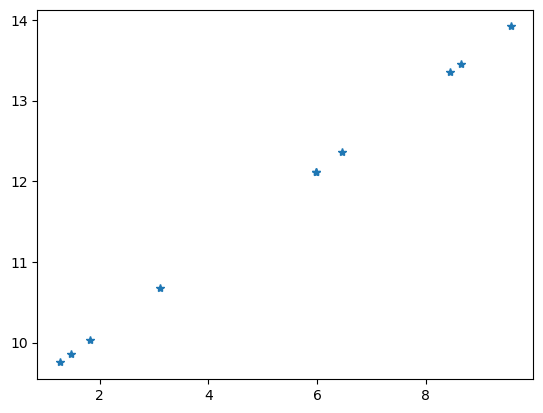

In [7]:
x, y = get_linear(n_d=1, sigma=0)
plt.plot(x[:, 0], y, '*')
plt.show()

true slopes: w = [3.66069742 7.33355981] ;  b = 1.4549213613191387


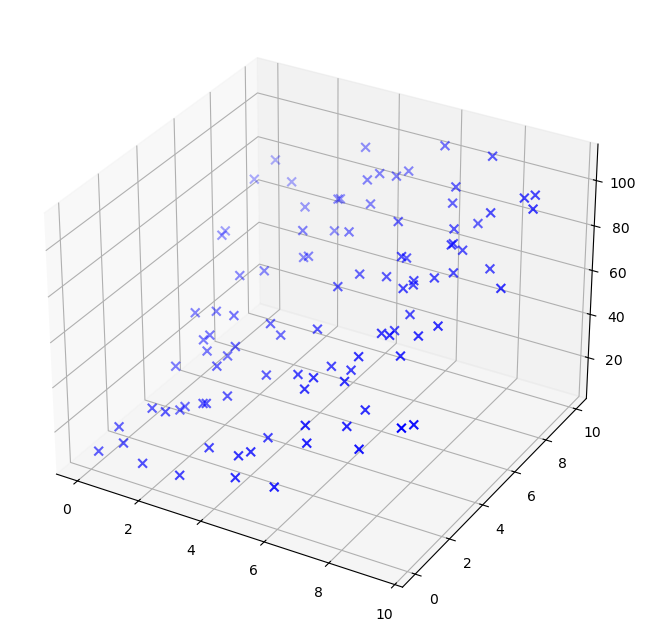

In [15]:
n_d = 2
x, y = get_linear(n_d=n_d, n_points=100)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0], x[:,1], y, marker='x', color='b',s=40)
plt.show()

## 2. House prices

Subset of the Ames Houses dataset: http://jse.amstat.org/v19n3/decock.pdf

In [17]:
def house_prices_dataset(return_df=False, price_max=400000, area_max=40000):
  path = 'data/AmesHousing.csv'

  df = pd.read_csv(path, na_values=('NaN', ''), keep_default_na=False)

  rename_dict = {k:k.replace(' ', '').replace('/', '') for k in df.keys()}
  df.rename(columns=rename_dict, inplace=True)

  useful_fields = ['LotArea',
                  'Utilities', 'OverallQual', 'OverallCond',
                  'YearBuilt', 'YearRemodAdd', 'ExterQual', 'ExterCond',
                  'HeatingQC', 'CentralAir', 'Electrical',
                  '1stFlrSF', '2ndFlrSF','GrLivArea',
                  'FullBath', 'HalfBath',
                  'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
                  'Functional','PoolArea',
                  'YrSold', 'MoSold'
                  ]
  target_field = 'SalePrice'

  df.dropna(axis=0, subset=useful_fields+[target_field], inplace=True)

  cleanup_nums = {'Street':      {'Grvl': 0, 'Pave': 1},
                  'LotFrontage': {'NA':0},
                  'Alley':       {'NA':0, 'Grvl': 1, 'Pave': 2},
                  'LotShape':    {'IR3':0, 'IR2': 1, 'IR1': 2, 'Reg':3},
                  'Utilities':   {'ELO':0, 'NoSeWa': 1, 'NoSewr': 2, 'AllPub': 3},
                  'LandSlope':   {'Sev':0, 'Mod': 1, 'Gtl': 3},
                  'ExterQual':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'ExterCond':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'BsmtQual':    {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'BsmtCond':    {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'BsmtExposure':{'NA':0, 'No':1, 'Mn': 2, 'Av': 3, 'Gd': 4},
                  'BsmtFinType1':{'NA':0, 'Unf':1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ':5, 'GLQ':6},
                  'BsmtFinType2':{'NA':0, 'Unf':1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ':5, 'GLQ':6},
                  'HeatingQC':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'CentralAir':  {'N':0, 'Y': 1},
                  'Electrical':  {'':0, 'NA':0, 'Mix':1, 'FuseP':2, 'FuseF': 3, 'FuseA': 4, 'SBrkr': 5},
                  'KitchenQual': {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'Functional':  {'Sal':0, 'Sev':1, 'Maj2': 2, 'Maj1': 3, 'Mod': 4, 'Min2':5, 'Min1':6, 'Typ':7},
                  'FireplaceQu': {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'PoolQC':      {'NA':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'Fence':       {'NA':0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv':4},
                  }

  df_X = df[useful_fields].copy()
  df_X.replace(cleanup_nums, inplace=True)  # convert continous categorial variables to numerical
  df_Y = df[target_field].copy()

  x = df_X.to_numpy().astype(np.float32)
  y = df_Y.to_numpy().astype(np.float32)

  if price_max>0:
    idxs = y<price_max
    x = x[idxs]
    y = y[idxs]

  if area_max>0:
    idxs = x[:,0]<area_max
    x = x[idxs]
    y = y[idxs]

  return (x, y, df) if return_df else (x,y)

In [19]:
def house_prices_dataset_normed():
    x, y = house_prices_dataset(return_df=False, price_max=-1, area_max=-1)

    scaler=StandardScaler()
    features_scaled=scaler.fit_transform(x)

    return features_scaled

In [21]:
x, y, df = house_prices_dataset(return_df=True)
print(x.shape, y.shape)
df.head()

(2847, 24) (2847,)


C:\Users\vuill\AppData\Local\Temp\ipykernel_6968\1147968421.py:47: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_X.replace(cleanup_nums, inplace=True)  # convert continous categorial variables to numerical


,Order,PID,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NA,IR1,Lvl,...,0,NA,NA,NA,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NA,Reg,Lvl,...,0,NA,MnPrv,NA,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NA,IR1,Lvl,...,0,NA,NA,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NA,Reg,Lvl,...,0,NA,NA,NA,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NA,IR1,Lvl,...,0,NA,MnPrv,NA,0,3,2010,WD,Normal,189900


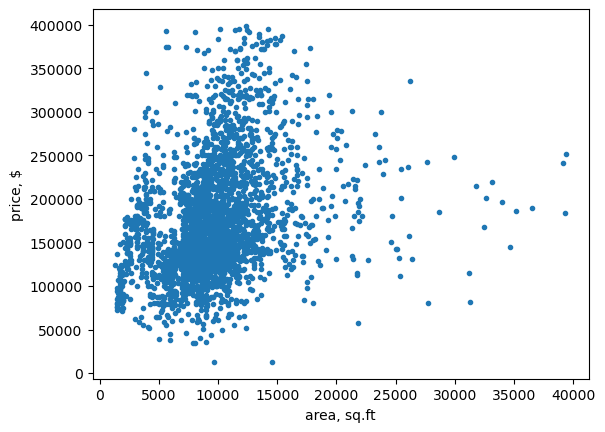

In [23]:
plt.plot(x[:, 0], y, '.')
plt.xlabel('area, sq.ft')
plt.ylabel('price, $');
plt.show()

## 3. Blobs

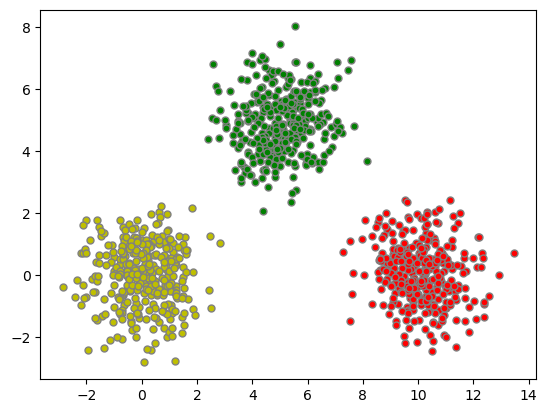

In [25]:
x, y = make_blobs(n_samples=1000, centers=[[0,0], [5,5], [10, 0]])
colors = "ygr"
for i, color in enumerate(colors):
    idx = y == i
    plt.scatter(x[idx, 0], x[idx, 1], c=color, edgecolor='gray', s=25)
plt.show()

## 4. MNIST

The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. The digits have been size-normalized and centered in a fixed-size image.
It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting (taken from http://yann.lecun.com/exdb/mnist/). Each example is a 28x28 grayscale image and the dataset can be readily downloaded from Tensorflow.

In [27]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Let's check few samples:

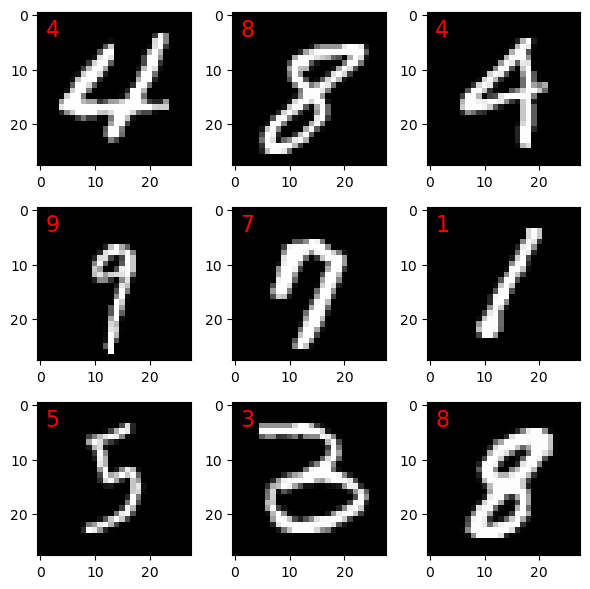

In [29]:
n = 3
fig, ax = plt.subplots(n, n, figsize=(2*n, 2*n))
ax = [ax_xy for ax_y in ax for ax_xy in ax_y]
for axi, im_idx in zip(ax, np.random.choice(len(train_images), n**2)):
  im = train_images[im_idx]
  im_class = train_labels[im_idx]
  axi.imshow(im, cmap='gray')
  axi.text(1, 4, f'{im_class}', color='r', size=16)
  axi.grid(False)
plt.tight_layout()
plt.show()

## 5. Fashion MNIST

`Fashion-MNIST` is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. (from https://github.com/zalandoresearch/fashion-mnist)

In [31]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Let's check few samples:

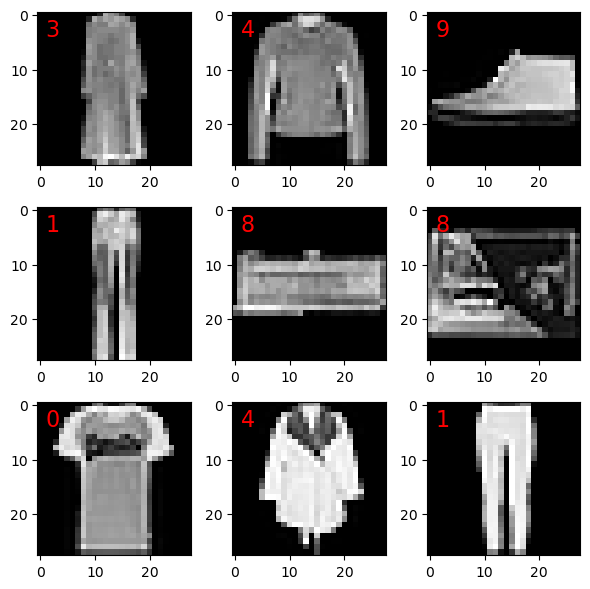

In [33]:
n = 3
fig, ax = plt.subplots(n, n, figsize=(2*n, 2*n))
ax = [ax_xy for ax_y in ax for ax_xy in ax_y]
for axi, im_idx in zip(ax, np.random.choice(len(train_images), n**2)):
  im = train_images[im_idx]
  im_class = train_labels[im_idx]
  axi.imshow(im, cmap='gray')
  axi.text(1, 4, f'{im_class}', color='r', size=16)
  axi.grid(False)
plt.tight_layout()
plt.show()

Each of the training and test examples is assigned to one of the following labels:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

In this course we will use several synthetic and real-world datasets to illustrate the behavior of the models and exercise our skills.

## 1. Data visualization and low-dimensional embeddings

**Unsupervised learning techniques** differ from supervised ones from the fact that data are not labelled (no supervision).

We do not aim at fitting a mapping from $X$ to $Y$, but to understand patterns in the data cloud $X$.

Many datasets have a large number of features $D$ (design matrix of shape $N \times D$). Dimensionality reduction aims at reducing the number of features $M$ (new design matrix of shape $N \times M$), with $M \ll D$, without losing information.

### Applications:

- **EDA**: When $M=2$ or $M=3$ the dataset can also be visualized in a 2D or 3D plot, usable to perform exploratory data analysis, build visualization Apps and supporting feature engineering for complex data structures.

- **DATA UNDERSTANDING**: Umap visualization may highlight dataset structures and outliers/data with poor quality or measurement errors. 

- **NOISE REDUCTION**: by performing dimensionality reduction the noise may be removed. This may simplify downstreams tasks (e.g. clustering) or fitting downstream models, using the reduced features instead of the original one.

- **DATA COMPRESSION**: this is useful to train downstream models. 

### Methods:

Embedding techniques start from a local description of the environment of each sample point in the original space:

- `t-Sne` uses a `statistical description` of the environment of a sample point ;
- `UMAP` describes the `topology` of the environment through a generalized "triangulation" (simplex decomposition) ;

The projection on the low-dimensional space is optimized in order to match as much as possible the description of the local environment.

It is not the goal of this introduction to discuss the derivation of such approaches, which can be found in the references:

https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf

https://arxiv.org/pdf/1802.03426.pdf



### Utilization in Python and examples

To begin with, we create a t-SNE object that we are going to use.

In [35]:
tsne_model = TSNE(perplexity=30, n_components=2, learning_rate=200, early_exaggeration=4.0,init='pca',
                      n_iter=2000, random_state=2233212, metric='euclidean', verbose=100 )

umap_model = umap.UMAP(n_neighbors=30, n_components=2, random_state=1711)

### Example 1: the Heart dataset

In [7]:
data= load_ex2_data_pca(seed=13423, n_add=20)

In [8]:
data

array([[-0.01140711,  0.06376451,  0.00590631, ...,  0.31531994,
        -0.35451896,  0.21230201],
       [-0.00604648,  0.06497993, -0.00379757, ...,  0.30131926,
        -0.34483793,  0.20635285],
       [-0.01100969,  0.02250595,  0.01437446, ...,  0.13634644,
        -0.1457093 ,  0.08744727],
       ...,
       [ 0.0069414 , -0.06442415, -0.09532022, ..., -0.23086975,
         0.28791068, -0.17968861],
       [ 0.0538207 , -0.04913651, -0.00549859, ..., -0.26251781,
         0.2840405 , -0.17293126],
       [-0.00440556, -0.04801674, -0.02241828, ..., -0.31894796,
         0.33082842, -0.17234285]])

In [37]:
data.shape

(651, 10)

In [39]:
type(data)

numpy.ndarray

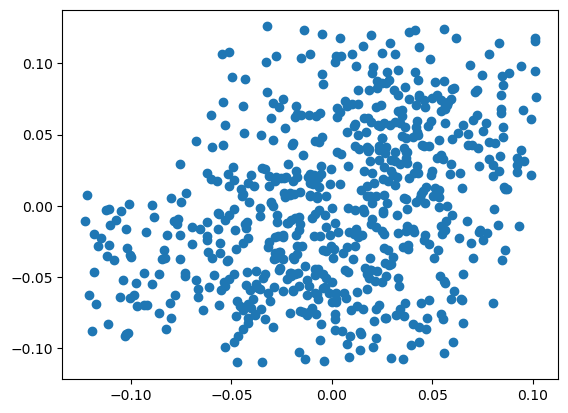

In [39]:
plt.plot(data[:,0], data[:,1],'o')

In [41]:
data= load_ex2_data_pca(seed=1235, n_add=20)

tsne_model = TSNE(perplexity=30, n_components=2, learning_rate=200, early_exaggeration=4.0,init='pca',
                      n_iter=300, random_state=2233212, metric='euclidean', verbose=1 )

tsne_heart = tsne_model.fit_transform(data)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 651 samples in 0.003s...
[t-SNE] Computed neighbors for 651 samples in 0.030s...
[t-SNE] Computed conditional probabilities for sample 651 / 651
[t-SNE] Mean sigma: 0.060286
[t-SNE] KL divergence after 250 iterations with early exaggeration: 10.423696
[t-SNE] KL divergence after 300 iterations: 0.607569


In [43]:
import numpy as np
from sklearn.manifold import TSNE
from utils.routines import *
import matplotlib.pyplot as plt

data= load_ex2_data_pca(seed=1235, n_add=20)

tsne_model = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3, verbose=1)

tsne_heart = tsne_model.fit_transform(data)

[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Indexed 651 samples in 0.002s...
[t-SNE] Computed neighbors for 651 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 651 / 651
[t-SNE] Mean sigma: 0.025506
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.112373
[t-SNE] KL divergence after 1000 iterations: 0.924471


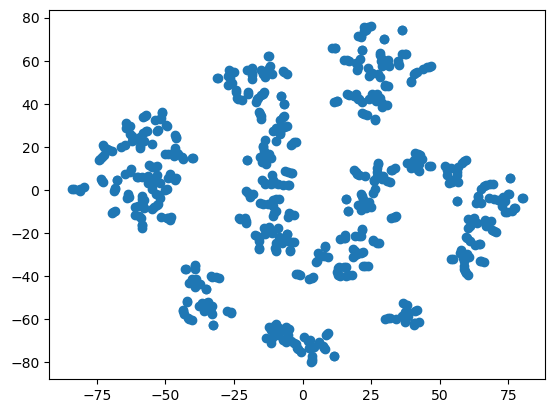

In [45]:
plt.scatter(tsne_heart[:,0],tsne_heart[:,1])
plt.show()

In [49]:
data= load_ex2_data_pca(seed=1235, n_add=20)

tsne_model = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10, verbose=1)

tsne_heart = tsne_model.fit_transform(data)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 651 samples in 0.002s...
[t-SNE] Computed neighbors for 651 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 651 / 651
[t-SNE] Mean sigma: 0.042182
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.553383
[t-SNE] KL divergence after 1000 iterations: 0.818458


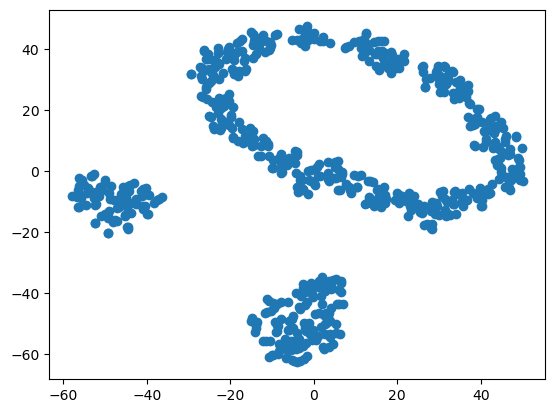

In [50]:
plt.scatter(tsne_heart[:,0],tsne_heart[:,1])
plt.show()

C:\Users\vuill\anaconda3\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


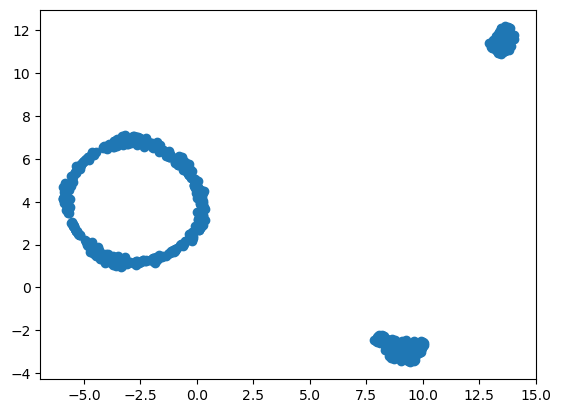

In [53]:
umap_model = umap.UMAP(n_neighbors=50, n_components=2, random_state=1711)

umap_hart = umap_model.fit_transform(data)
plt.scatter(umap_hart[:, 0], umap_hart[:, 1])
plt.show()

### Example 2: Mnist dataset

In [54]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

n_examples = 5000
data=train_images[:n_examples,:].reshape(n_examples,-1)
data=data/255

labels=train_labels[:n_examples]

In [55]:
labels

array([5, 0, 4, ..., 2, 1, 2], dtype=uint8)

In [ ]:
# not to run on COLAB

# tsne_model = TSNE(perplexity=10, n_components=2, learning_rate=200,
#                   early_exaggeration=4.0,init='pca',
#                   n_iter=2000, random_state=2233212,
#                   metric='euclidean', verbose=100, n_jobs=1)

# tsne_mnist = tsne_model.fit_transform(data)

# plt.scatter(tsne_mnist[:,0],tsne_mnist[:,1],c=labels,s=10)
# plt.show()

C:\Users\vuill\anaconda3\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


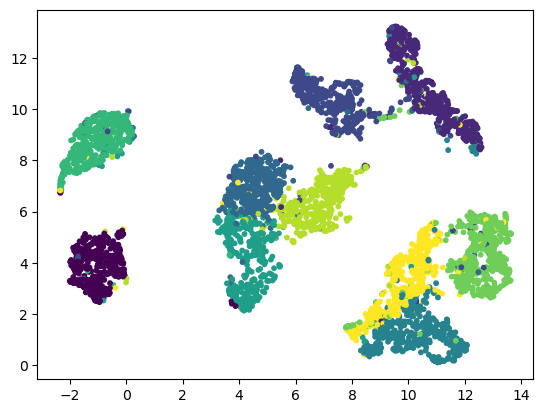

In [56]:
umap_model = umap.UMAP(n_neighbors=10, n_components=2, random_state=1711)
umap_mnist = umap_model.fit_transform(data)
plt.scatter(umap_mnist[:, 0], umap_mnist[:, 1], c=labels, s=10)
plt.show()

### Example 3: Fashion_Mnist dataset

In [58]:
fmnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fmnist.load_data()

n_examples = 5000
data=train_images[:n_examples,:].reshape(n_examples,-1)
data=data/255

labels=train_labels[:n_examples]

In [219]:
# not to run on COLAB

# tsne_model = TSNE(perplexity=50, n_components=2, learning_rate=200, early_exaggeration=4.0,init='pca',
#                      n_iter=1000, random_state=2233212, metric='euclidean', verbose=100 )

# tsne_fmnist = tsne_model.fit_transform(data)

# plt.scatter(tsne_fmnist[:,0],tsne_fmnist[:,1],c=labels,s=10)
# plt.show()

C:\Users\vuill\anaconda3\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


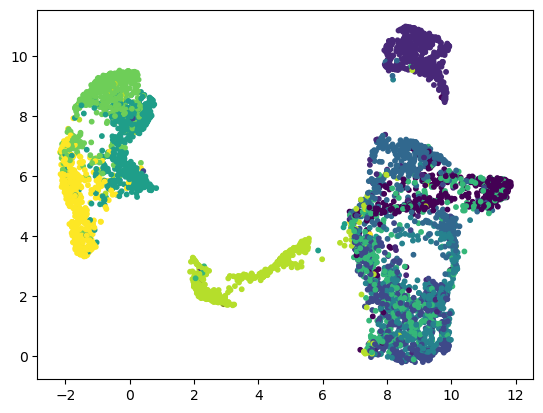

In [61]:
umap_model = umap.UMAP(n_neighbors=50, n_components=2, random_state=1711)
umap_fmnist = umap_model.fit_transform(data)
plt.scatter(umap_fmnist[:, 0], umap_fmnist[:, 1], c=labels, s=10)
plt.show()

### Example 4: AMES dataset

In the case of the AMES dataset we must normalize somehow the dataset. Why?

In [62]:
data = house_prices_dataset_normed()
x, y, df = house_prices_dataset(return_df=True, price_max=-1, area_max=-1)

C:\Users\vuill\AppData\Local\Temp\ipykernel_20208\1147968421.py:47: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_X.replace(cleanup_nums, inplace=True)  # convert continous categorial variables to numerical
C:\Users\vuill\AppData\Local\Temp\ipykernel_20208\1147968421.py:47: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_X.replace(cleanup_nums, inplace=True)  # convert continous categorial variables to numerical


C:\Users\vuill\anaconda3\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


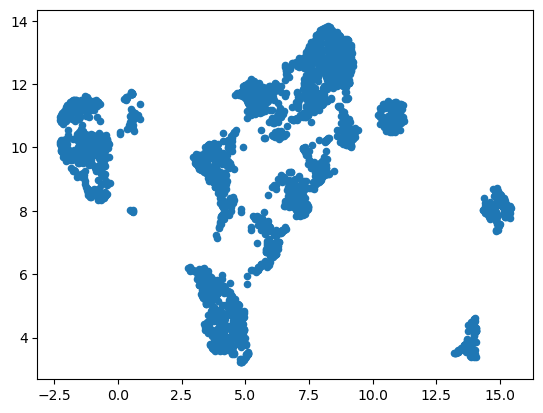

In [63]:
umap_model = umap.UMAP(n_neighbors=30, n_components=2, random_state=1711)
umap_houses = umap_model.fit_transform(data)
plt.scatter(umap_houses[:, 0], umap_houses[:, 1], s=20)
plt.show()

In such a situation we do not have 'labels' to superimpose. To understand what are the features characterizing each clusters it time consuming and there is no general-purpose method.

The following techniques can be used:

1. **Visualization of Individual points:** Make an interactive App (e.g. using dash) that permits to visualize points quickly (e.g. if the dataset is made of images or texts)

2. **Colour plots:** Color the points according to a selected variable F and check if points get mixed. Maybe sub-clusters appear. 

Using clustering techniques (you will here more about them next session), one can attach a cluster label to each point. After this step, an other range of exploration methodologies can be performed:

3. **Visualization of Centroids:** Make the mean of the each features across all members of one cluster. Compare between clusters. 

4. **Analyze distributions:** Make a descriptive analysis of the populations in the different clusters.

5. **Use cluster indexes as labels and apply supervised machine learning methods.** 

As an example we start an analysis using approach 5:

In [80]:
pip install --upgrade pip setuptools wheel

  Using cached setuptools-75.1.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached wheel-0.44.0-py3-none-any.whl.metadata (2.3 kB)
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
    --------------------------------------- 0.0/1.8 MB 660.6 kB/s eta 0:00:03
   -- ------------------------------------- 0.1/1.8 MB 1.4 MB/s eta 0:00:02
   --------- ------------------------------ 0.5/1.8 MB 3.5 MB/s eta 0:00:01
   ---------------- ----------------------- 0.7/1.8 MB 4.2 MB/s eta 0:00:01
   --------------------- ------------------ 1.0/1.8 MB 4.4 MB/s eta 0:00:01
   ------------------------------ --------- 1.4/1.8 MB 5.2 MB/s eta 0:00:01
   ------------------------------------- -- 1.7/1.8 MB 5.4 MB/s eta 0:00:01
   ---------------------------------------- 1.8/1.8 MB 5.3 MB/s eta 0:00:00
Using cached setuptools-75.1.0-py3-none-any.whl (1.2 MB)
Using cached wheel-0.44.0-py3-none-any.whl (67 kB)
  Attempting uninstall: wheel
    Found existing installation: wheel 0.43.0
    Un

In [84]:
pip install --install-option="--no-cython" hdbscan

Note: you may need to restart the kernel to use updated packages.



Usage:   
  C:\Users\vuill\anaconda3\python.exe -m pip install [options] <requirement specifier> [package-index-options] ...
  C:\Users\vuill\anaconda3\python.exe -m pip install [options] -r <requirements file> [package-index-options] ...
  C:\Users\vuill\anaconda3\python.exe -m pip install [options] [-e] <vcs project url> ...
  C:\Users\vuill\anaconda3\python.exe -m pip install [options] [-e] <local project path> ...
  C:\Users\vuill\anaconda3\python.exe -m pip install [options] <archive url/path> ...

no such option: --install-option


In [69]:
pip install hdbscan

  Using cached hdbscan-0.8.38.post1.tar.gz (5.8 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build hdbscan
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  exit code: 1
  
  [32 lines of output]
  C:\Users\vuill\AppData\Local\Temp\pip-build-env-wq21x_n0\overlay\Lib\site-packages\setuptools\_distutils\dist.py:261: UserWarning: Unknown distribution option: 'test_suite'
    warnings.warn(msg)
  C:\Users\vuill\AppData\Local\Temp\pip-build-env-wq21x_n0\overlay\Lib\site-packages\setuptools\_distutils\dist.py:261: UserWarning: Unknown distribution option: 'tests_require'
    warnings.warn(msg)
  C:\Users\vuill\AppData\Local\Temp\pip-build-env-wq21x_n0\overlay\Lib\site-packages\setuptools\dist.py:294: InformationOnly: Normalizing '0.8.38-1' to '0.8.38.post1'
    self.metadata.version = self._normalize_version(self.metadata.version)
  running bdist_wheel
  running build
  running build_py
  creating build\lib.win-amd64-cpython-312\hdbscan
  copying hdbscan\branches.py -> build\lib.win-amd64-cpython-312\hdbscan
  copying hdbscan\flat.py -> build\lib.win-amd64-cpython-312\hdbscan
  copying hdbscan\hdbscan_.

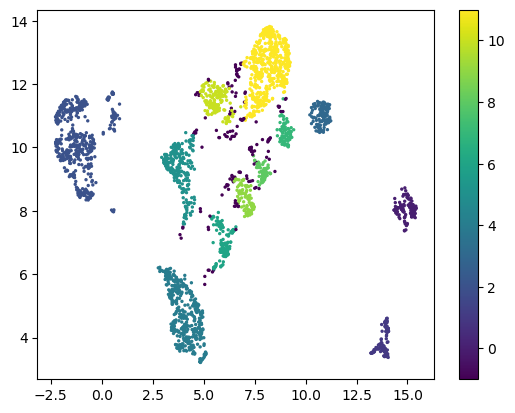

In [71]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=30, gen_min_span_tree=True)
clusterer.fit(umap_houses)

scatter = plt.scatter(umap_houses[:, 0], umap_houses[:, 1], c=clusterer.labels_, cmap='viridis', s=2)
plt.colorbar(scatter)

labels=clusterer.labels_
classes=set(labels)-set([-1])

In [73]:
useful_fields = ['LotArea',
                'Utilities', 'OverallQual', 'OverallCond',
                'YearBuilt', 'YearRemodAdd', 'ExterQual', 'ExterCond',
                'HeatingQC', 'CentralAir', 'Electrical',
                '1stFlrSF', '2ndFlrSF','GrLivArea',
                'FullBath', 'HalfBath',
                'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
                'Functional','PoolArea',
                'YrSold', 'MoSold'
                ]
df = pd.DataFrame(data, columns=useful_fields)
df['cluster']=clusterer.labels_

# Select only the points that have been assigned to a cluster (NB: hdbscan may fail to assign a point to a cluster)
df_2=df[df['cluster']!=-1]
df_2=df_2.sort_values(by='cluster')

In [75]:
n_clusters=len(set(df_2['cluster']))
print(n_clusters)
for i in range(n_clusters):
    pop=df_2[df_2['cluster']==i].shape[0]
    print(f'Cluster {i} has population: {pop}')

12
Cluster 0 has population: 154
Cluster 1 has population: 127
Cluster 2 has population: 536
Cluster 3 has population: 134
Cluster 4 has population: 436
Cluster 5 has population: 260
Cluster 6 has population: 143
Cluster 7 has population: 82
Cluster 8 has population: 79
Cluster 9 has population: 106
Cluster 10 has population: 168
Cluster 11 has population: 547


Accuracy: 0.9855855855855856
[[527   1]
 [  7  20]]
Accuracy: 1.0
[[525   0]
 [  0  30]]
Accuracy: 0.9711711711711711
[[443   4]
 [ 12  96]]
Accuracy: 0.9711711711711711
[[528   0]
 [ 16  11]]
Accuracy: 0.9855855855855856
[[457   2]
 [  6  90]]
Accuracy: 0.9891891891891892
[[501   3]
 [  3  48]]
Accuracy: 0.9747747747747748
[[529   1]
 [ 13  12]]
Accuracy: 0.9783783783783784
[[537   1]
 [ 11   6]]
Accuracy: 0.9765765765765766
[[541   0]
 [ 13   1]]
Accuracy: 0.9765765765765766
[[539   0]
 [ 13   3]]
Accuracy: 0.9333333333333333
[[515   0]
 [ 37   3]]
Accuracy: 0.9243243243243243
[[442   9]
 [ 33  71]]


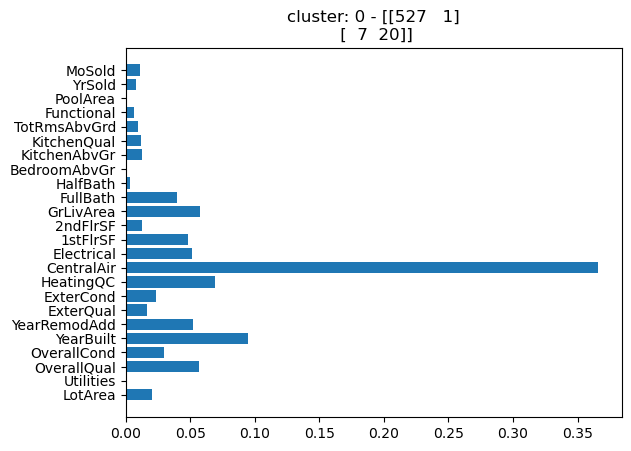

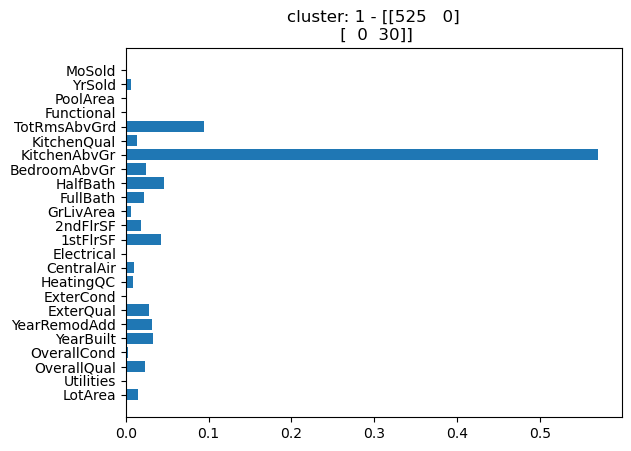

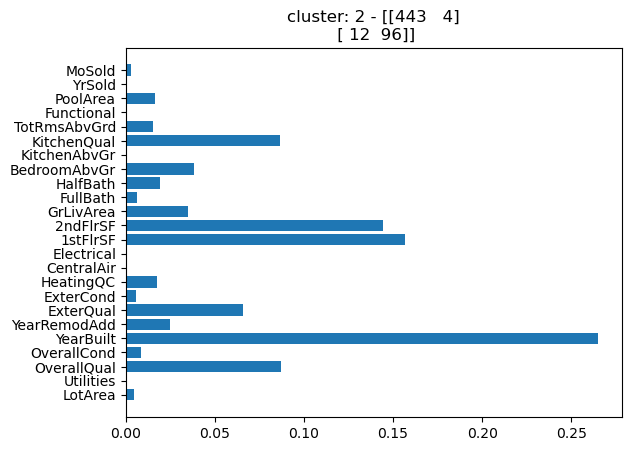

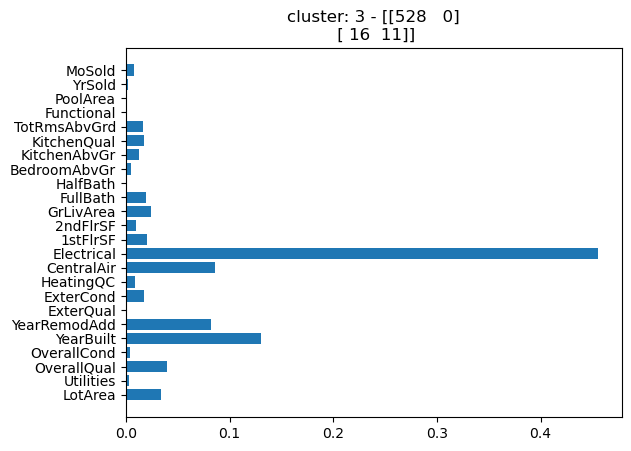

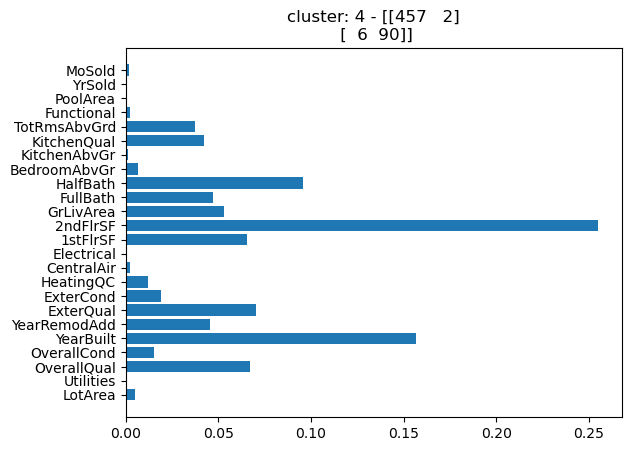

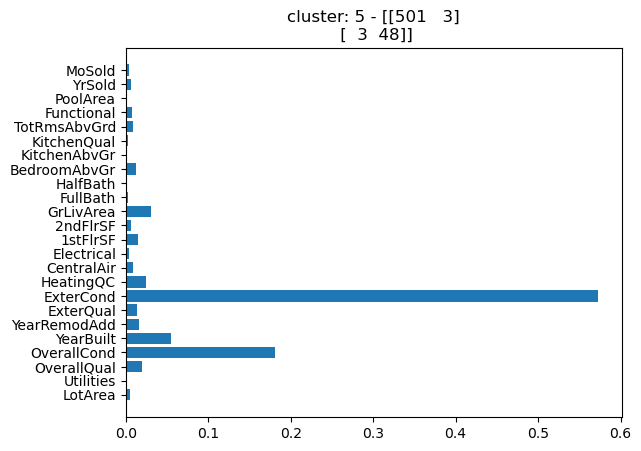

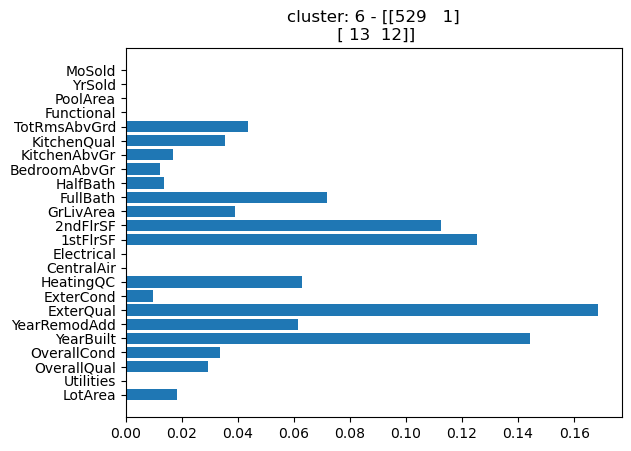

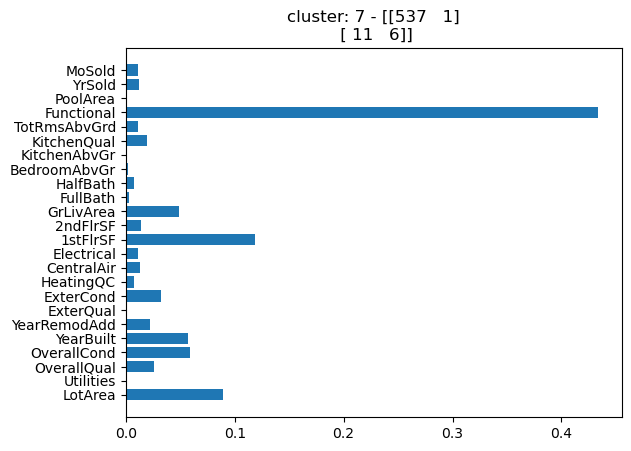

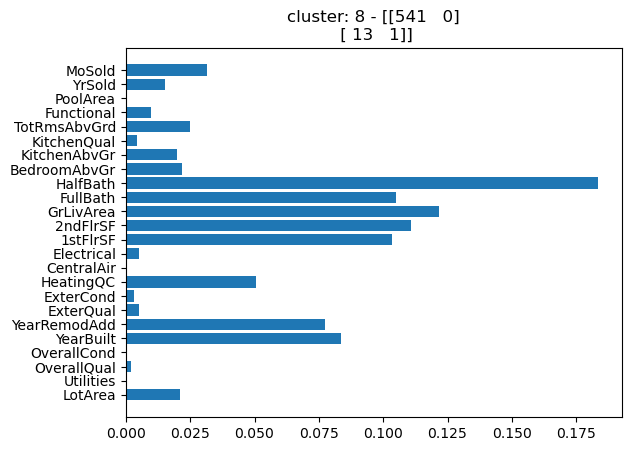

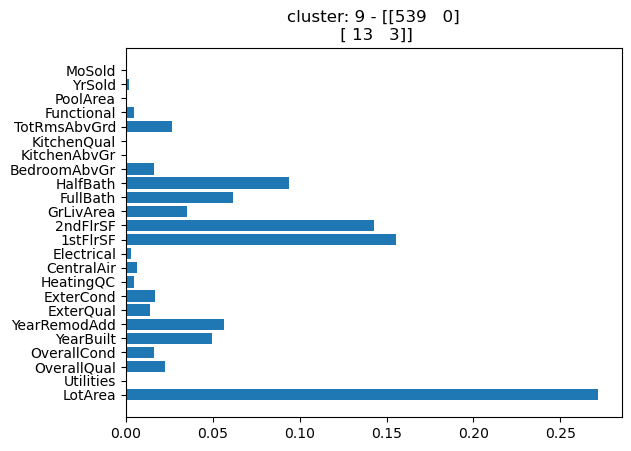

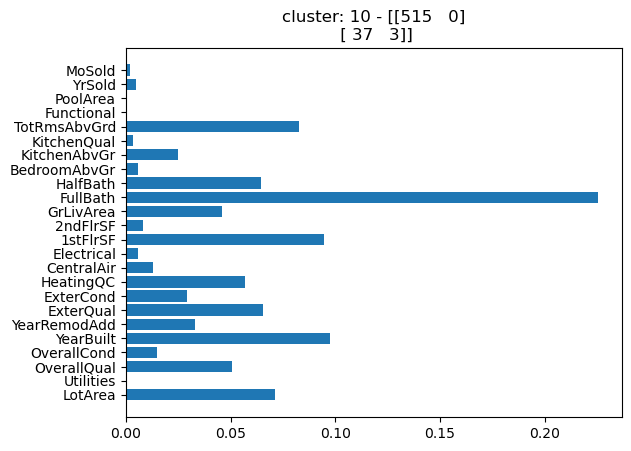

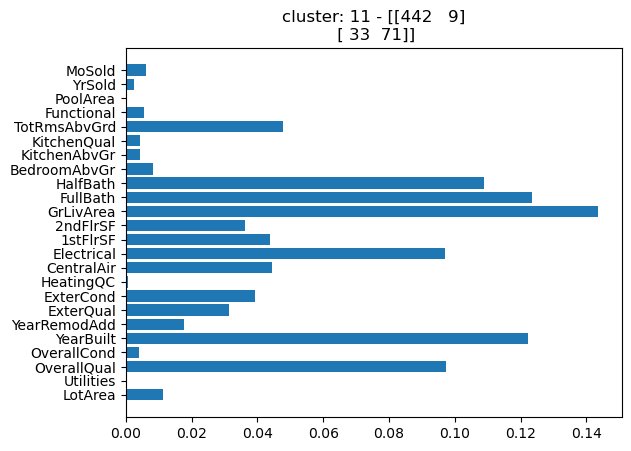

In [77]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


for cluster in range(n_clusters):
        X = df_2.drop('cluster', axis=1)  
        y = df_2['cluster']            
        # binarization
        y = [1 if i==cluster else 0 for i in y]
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        rf_model = RandomForestClassifier(n_estimators=10, random_state=42, max_depth=5)
        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        # Print evaluation metrics
        print(f"Accuracy: {accuracy}") ## --> Note that this is an inbalanced dataset
        print(conf_matrix)
        plt.figure()
        plt.barh(useful_fields,
                rf_model.feature_importances_)
        plt.title(f'cluster: {cluster} - {conf_matrix}')

NB: a similar result approach can be pursued following the SHAP method.

### Example 5: [An example from NLP](https://www.kaggle.com/code/matthewmaddock/nlp-arxiv-dataset-transformers-and-umap)

# EXERCISE 1: Umap with Wine or Breast-Cancer dataset

In [81]:
# This is an open exercise in order to get familiarity with UMAP plots.

# Dowloand the Wine and Breast-Cancer dataset, after checking the documentation:

from sklearn.datasets import load_wine
wine = load_wine()

X_wine = wine.data
y_wine = wine.target

from sklearn.datasets import load_breast_cancer

# Load the Breast Cancer dataset
breast_cancer = load_breast_cancer()
X_cancer = breast_cancer.data
y_cancer = breast_cancer.target

# 

wine_df = pd.DataFrame(X_wine, columns=wine.feature_names)
cancer_df = pd.DataFrame(X_cancer, columns=breast_cancer.feature_names)

# Play with the umap visualizations. E.g. try:

# 1. Normalize the data vs non normalizing it.

from sklearn.preprocessing import MinMaxScaler
import umap
import matplotlib.pyplot as plt

# Normalize the data
scaler_wine = MinMaxScaler()
X_wine_normalized = scaler_wine.fit_transform(X_wine)

scaler_cancer = MinMaxScaler()
X_cancer_normalized = scaler_cancer.fit_transform(X_cancer)

# 2. Check different UMAP parameters (e.g. min_cluster_size) and see how umap reacts.



# 3. Using the same parameters, are the final plots stable? 



# 4. Check the relation between the clusters and the target variable (Approach 2). Was the target variable used to make the plot?


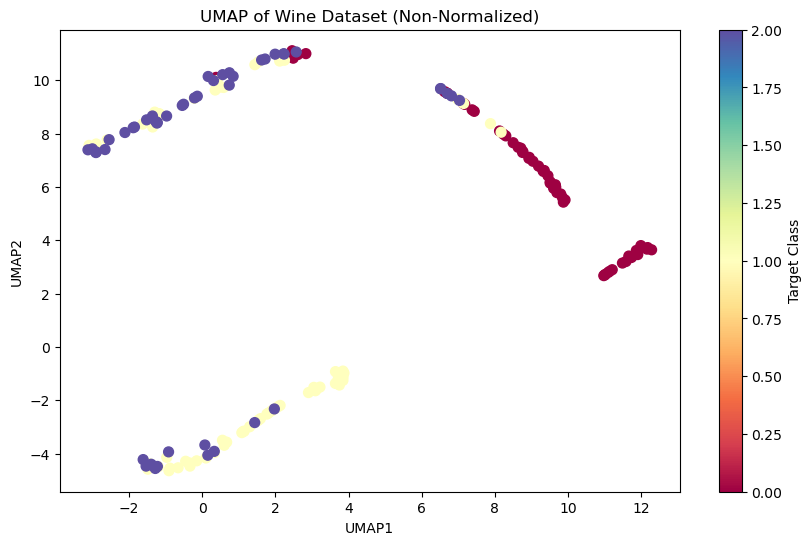

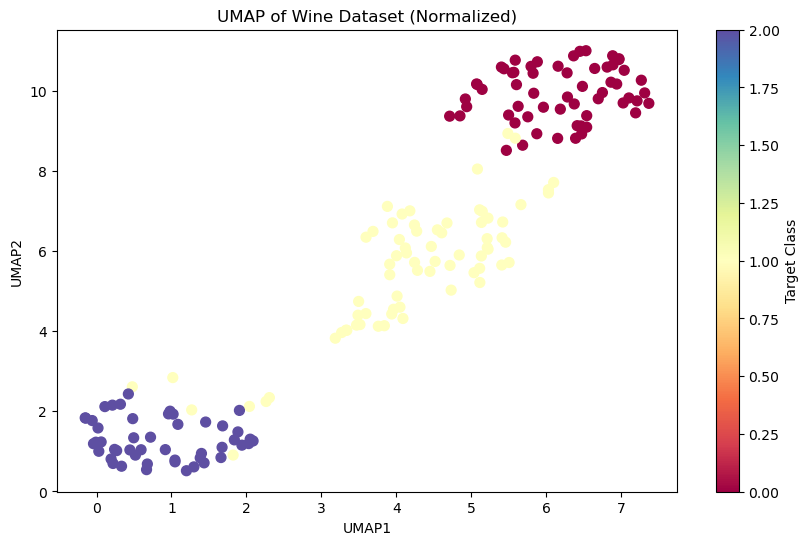

In [83]:
# UMAP for Wine dataset (non-normalized)
umap_wine = umap.UMAP()
wine_umap = umap_wine.fit_transform(X_wine)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(wine_umap[:, 0], wine_umap[:, 1], c=y_wine, cmap='Spectral', s=50)
plt.title('UMAP of Wine Dataset (Non-Normalized)')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.colorbar(label='Target Class')
plt.show()

# UMAP for Wine dataset (normalized)
wine_umap_normalized = umap.UMAP().fit_transform(X_wine_normalized)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(wine_umap_normalized[:, 0], wine_umap_normalized[:, 1], c=y_wine, cmap='Spectral', s=50)
plt.title('UMAP of Wine Dataset (Normalized)')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.colorbar(label='Target Class')
plt.show()

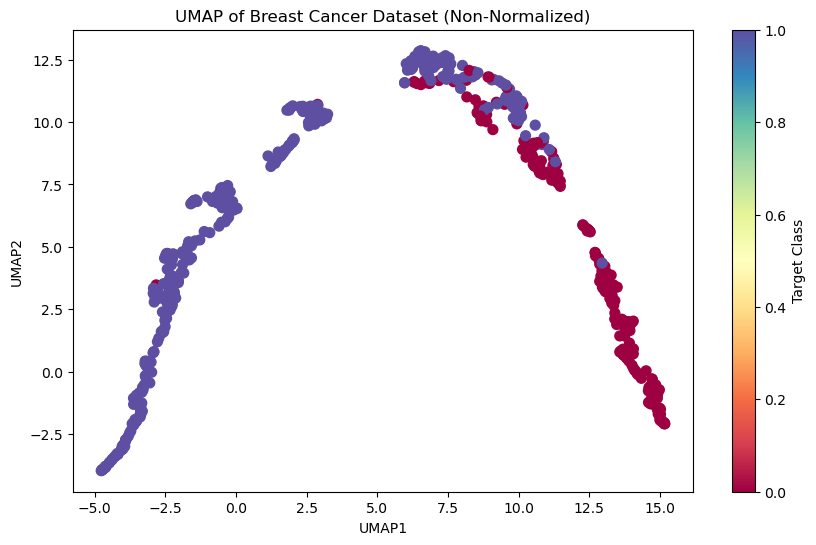

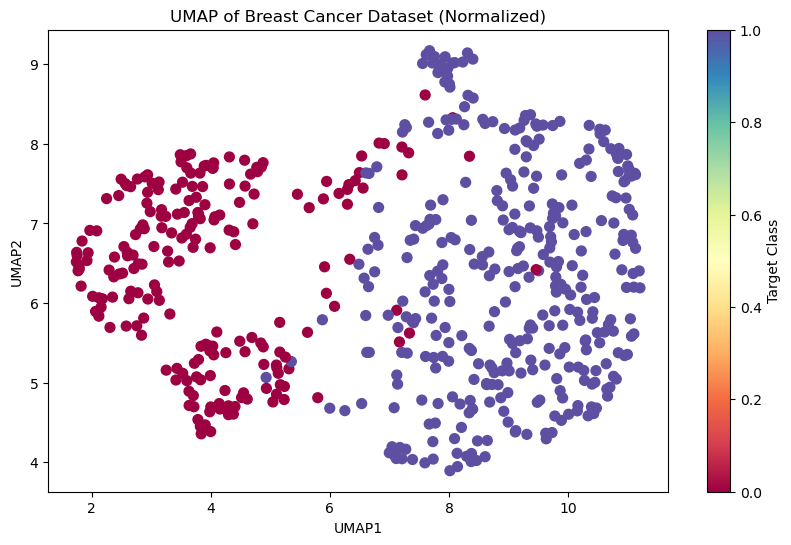

In [85]:
# UMAP for Breast Cancer dataset (non-normalized)
umap_cancer = umap.UMAP()
cancer_umap = umap_cancer.fit_transform(X_cancer)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(cancer_umap[:, 0], cancer_umap[:, 1], c=y_cancer, cmap='Spectral', s=50)
plt.title('UMAP of Breast Cancer Dataset (Non-Normalized)')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.colorbar(label='Target Class')
plt.show()

# UMAP for Breast Cancer dataset (normalized)
cancer_umap_normalized = umap.UMAP().fit_transform(X_cancer_normalized)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(cancer_umap_normalized[:, 0], cancer_umap_normalized[:, 1], c=y_cancer, cmap='Spectral', s=50)
plt.title('UMAP of Breast Cancer Dataset (Normalized)')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.colorbar(label='Target Class')
plt.show()

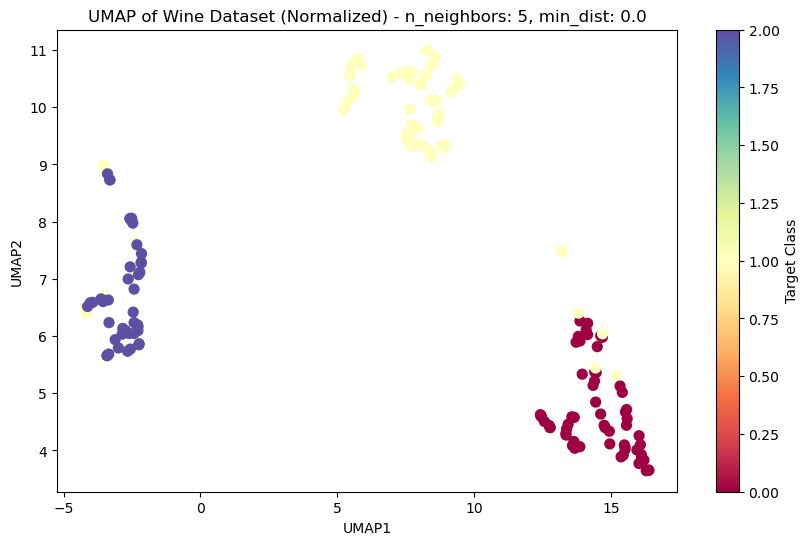

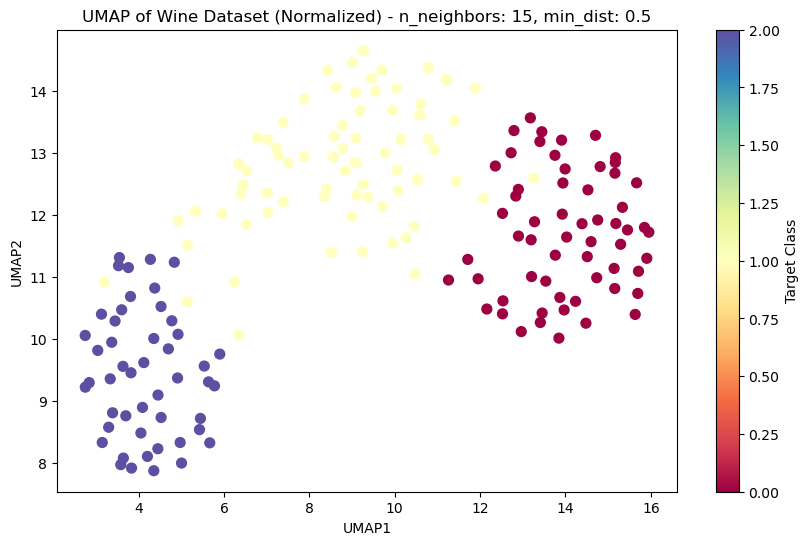

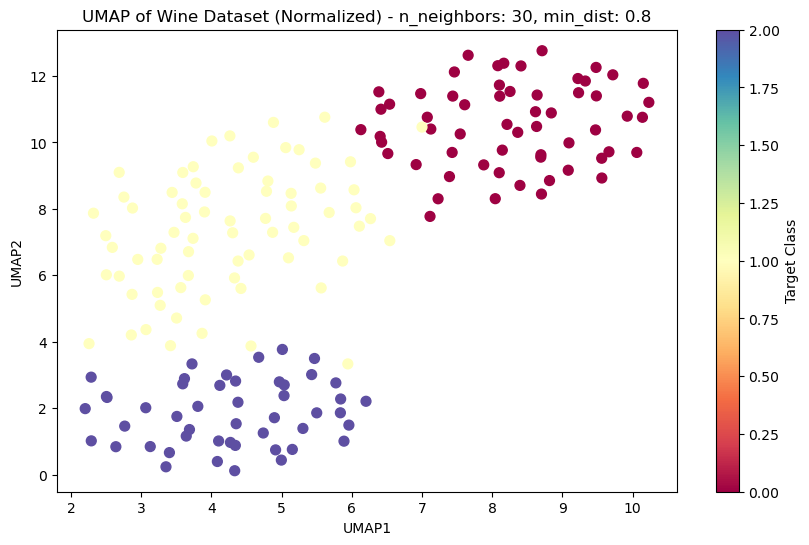

In [87]:
# Parameters to experiment with
umap_params = [
    {'n_neighbors': 5, 'min_dist': 0.0},
    {'n_neighbors': 15, 'min_dist': 0.5},
    {'n_neighbors': 30, 'min_dist': 0.8}
]

# Visualizing UMAP for different parameters on Wine dataset
for params in umap_params:
    umap_wine = umap.UMAP(**params)
    wine_umap = umap_wine.fit_transform(X_wine_normalized)

    plt.figure(figsize=(10, 6))
    plt.scatter(wine_umap[:, 0], wine_umap[:, 1], c=y_wine, cmap='Spectral', s=50)
    plt.title(f'UMAP of Wine Dataset (Normalized) - n_neighbors: {params["n_neighbors"]}, min_dist: {params["min_dist"]}')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.colorbar(label='Target Class')
    plt.show()

C:\Users\vuill\anaconda3\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


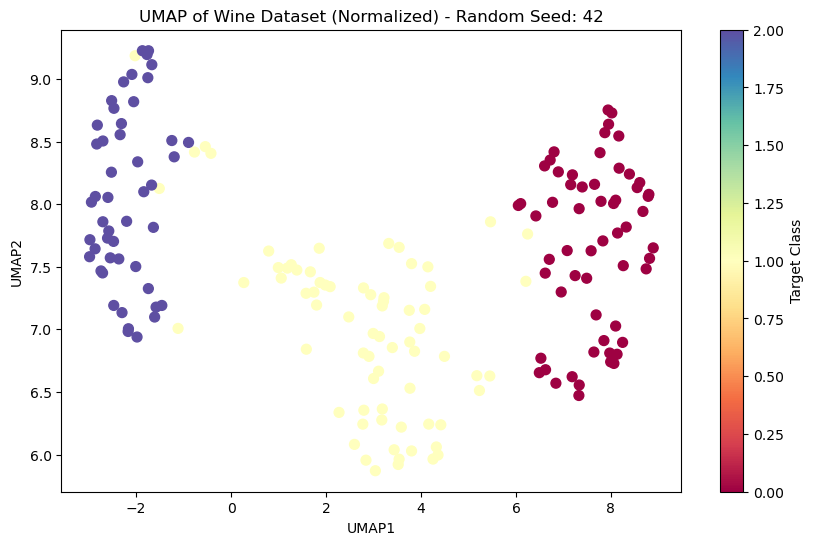

C:\Users\vuill\anaconda3\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


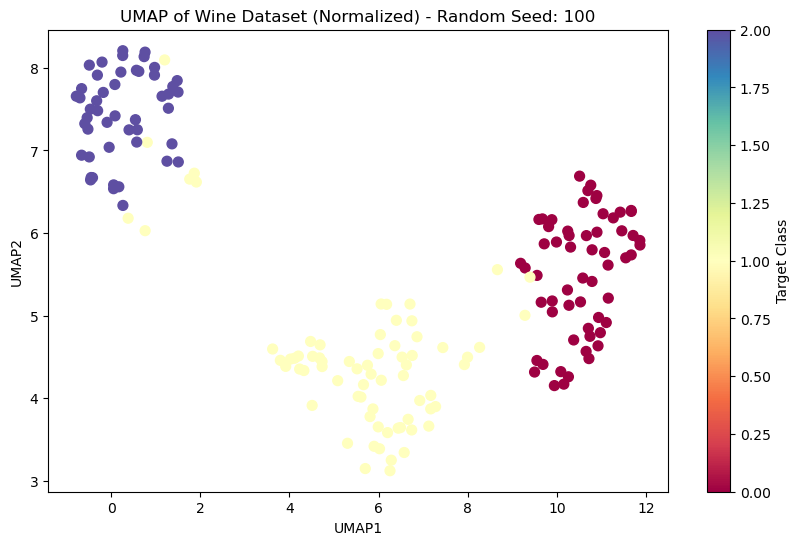

C:\Users\vuill\anaconda3\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


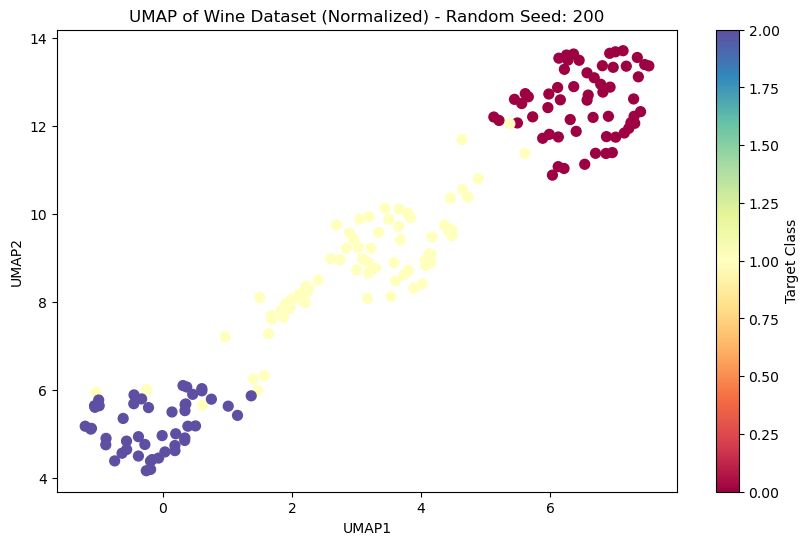

In [89]:
# Testing stability of UMAP
seeds = [42, 100, 200]
for seed in seeds:
    umap_wine = umap.UMAP(random_state=seed)
    wine_umap = umap_wine.fit_transform(X_wine_normalized)

    plt.figure(figsize=(10, 6))
    plt.scatter(wine_umap[:, 0], wine_umap[:, 1], c=y_wine, cmap='Spectral', s=50)
    plt.title(f'UMAP of Wine Dataset (Normalized) - Random Seed: {seed}')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.colorbar(label='Target Class')
    plt.show()

## 2. Principal Component Analysis (PCA)

PCA can be considered as a dimensionality reduction technique where there is a constrain of the reducting to be a linear projection. As a consequence:

1- only few datasets can be projected to $M=2$ dimensions.

2- the amount of information that can be extracted is higher and is easier to interpret when the variables have all the same units and numerical.

Let's start with the example that we will use to make the theory more concrete. We will take a dataset from from kaggle https://www.kaggle.com/datasets/miroslavsabo/young-people-survey?resource=download (already downloaded for you in the folder `data`)

The datasets consists of the results of a survey about the music preferences of several students, arriving at the following dataset:

In [9]:
data=pd.read_csv("data/responses.csv")

In [10]:
data

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,...,Age,Height,Weight,Number of siblings,Gender,Left - right handed,Education,Only child,Village - town,House - block of flats
0,5.0,3.0,2.0,1.0,2.0,2.0,1.0,5.0,5.0,1.0,...,20.0,163.0,48.0,1.0,female,right handed,college/bachelor degree,no,village,block of flats
1,4.0,4.0,2.0,1.0,1.0,1.0,2.0,3.0,5.0,4.0,...,19.0,163.0,58.0,2.0,female,right handed,college/bachelor degree,no,city,block of flats
2,5.0,5.0,2.0,2.0,3.0,4.0,5.0,3.0,5.0,3.0,...,20.0,176.0,67.0,2.0,female,right handed,secondary school,no,city,block of flats
3,5.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,...,22.0,172.0,59.0,1.0,female,right handed,college/bachelor degree,yes,city,house/bungalow
4,5.0,3.0,4.0,3.0,2.0,4.0,3.0,5.0,3.0,1.0,...,20.0,170.0,59.0,1.0,female,right handed,secondary school,no,village,house/bungalow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,5.0,2.0,5.0,2.0,2.0,5.0,4.0,4.0,4.0,3.0,...,20.0,164.0,57.0,1.0,female,right handed,secondary school,no,city,house/bungalow
1006,4.0,4.0,5.0,1.0,3.0,4.0,1.0,4.0,1.0,1.0,...,27.0,183.0,80.0,5.0,male,left handed,masters degree,no,village,house/bungalow
1007,4.0,3.0,1.0,1.0,2.0,2.0,2.0,3.0,4.0,1.0,...,18.0,173.0,75.0,0.0,female,right handed,secondary school,yes,city,block of flats
1008,5.0,3.0,3.0,3.0,1.0,3.0,1.0,3.0,4.0,1.0,...,25.0,173.0,58.0,1.0,female,right handed,college/bachelor degree,no,city,block of flats


In [11]:
music_columns=data.columns[:19]
print(music_columns)
music_data=data[music_columns].dropna()

Index(['Music', 'Slow songs or fast songs', 'Dance', 'Folk', 'Country',
       'Classical music', 'Musical', 'Pop', 'Rock', 'Metal or Hardrock',
       'Punk', 'Hiphop, Rap', 'Reggae, Ska', 'Swing, Jazz', 'Rock n roll',
       'Alternative', 'Latino', 'Techno, Trance', 'Opera'],
      dtype='object')


In [12]:
music_data

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,Punk,"Hiphop, Rap","Reggae, Ska","Swing, Jazz",Rock n roll,Alternative,Latino,"Techno, Trance",Opera
0,5.0,3.0,2.0,1.0,2.0,2.0,1.0,5.0,5.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0
1,4.0,4.0,2.0,1.0,1.0,1.0,2.0,3.0,5.0,4.0,4.0,1.0,3.0,1.0,4.0,4.0,2.0,1.0,1.0
2,5.0,5.0,2.0,2.0,3.0,4.0,5.0,3.0,5.0,3.0,4.0,1.0,4.0,3.0,5.0,5.0,5.0,1.0,3.0
3,5.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,4.0,2.0,2.0,1.0,2.0,5.0,1.0,2.0,1.0
4,5.0,3.0,4.0,3.0,2.0,4.0,3.0,5.0,3.0,1.0,2.0,5.0,3.0,2.0,1.0,2.0,4.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,5.0,2.0,5.0,2.0,2.0,5.0,4.0,4.0,4.0,3.0,2.0,4.0,1.0,5.0,4.0,4.0,3.0,3.0,2.0
1006,4.0,4.0,5.0,1.0,3.0,4.0,1.0,4.0,1.0,1.0,4.0,1.0,1.0,2.0,3.0,1.0,3.0,4.0,1.0
1007,4.0,3.0,1.0,1.0,2.0,2.0,2.0,3.0,4.0,1.0,2.0,3.0,3.0,2.0,2.0,5.0,1.0,1.0,1.0
1008,5.0,3.0,3.0,3.0,1.0,3.0,1.0,3.0,4.0,1.0,1.0,2.0,2.0,3.0,2.0,5.0,2.0,2.0,1.0


The answers are of course correlated and we expect to have typical patterns recurring, that we define as people liking similar types of songs.

The patterns may be also mixing, for e.g. a class of people may like classic `Pop` and `Reggae`, but not `Latino`. An other class may like `Latino` and `Reggae`, but not `Pop`.

PCA will help to find these typical patterns and their number in a data driven fashion. As we will see these patterns will naturally appear when trying to compress data in a lower dimensional space.

### Theory overview.

We will look at PCA from the point of view of `dimensionaliy reduction`.

**Objective:** PCA is used for dimensionality reduction when we have a large number $D$ of features with non-trivial intercorrelation ( data redundancy ) and to isolate relevant features. The number of features $D$ defines the original dimension of the dataset. Each sample defines a vector of dimensionality $D$.


    QUESTION: what are the starting vectors in our survey dataset? How many do we have?

PCA provides a new set of $M$ uncorrelated features for every data point, with $M \le D$. The new features are:

- a linear combination of the original ones ;
- uncorrelated between each other ;

If $M \ll D$ we get an effective dimensionality reduction.

    QUESTION: Does the number of data points changes after applying PCA?

***MOTIVATION***

What do we need from a dimensionality reduction?

<img src="https://github.com/neworldemancer/DSF5/raw/master/figures/pca-theory.png" width="100%"/>

***REPRESENTATION***

Each data point indexed by $p=1..N$ starts from an original $D-$dimensional space:
$$x_p=(x_{p,1},...,x_{p,D})$$

We want to find another more economical representation with $M$ components:
$$x'_p=(x_{p,1},...,x_{p,M})$$

PCA does that by defining $D$ auxiliar vectors, called the `principal components` or `principal vectors`:

$$k_1=(k_{1,1},...,k_{1,D})$$
$$...$$
$$k_D=(k_{D,1},...,k_{D,D})$$

$$\mathbf k_{i'} \cdot \mathbf k_{j'} = \delta_{i',j'}$$

such that:

$$x'_{p,i'}=\mathbf x_p \cdot \mathbf k_{i'}, i'=1...D$$

How are these principal components chosen? How can prove that:

$$S^2=\frac{1}{N}\sum_{p=1}^{N}  |\mathbf{x}_p - \mathbf{\overline{x}}|^2=\sum_{i'=1}^{D}\left( \frac{1}{N}\sum_{p=1}^{N}  |x_{p,i'} - \overline{x'}_{i'}|^2\right) $$  
and therefore:

$$S^2=\epsilon_1+\epsilon_2+...+\epsilon_D$$

PCA finds principal vectors $\mathbf k$ such that $\epsilon_1$ is as largest as possible, $\epsilon_2<\epsilon_1$ is such that $\epsilon_1+\epsilon_2$ is as largest as possible, and so on. Therefore truncating the summation the error is as small as possible among all possible choices all $k$-vectors. The $\epsilon$ are called the `explained variance` values.

The ratios:

$$\rho_1=\epsilon_1/S^2,\rho_2=\epsilon_2/S^2,...$$

are called the `explained variance ratio` values, and their cumulated brothers:

$$r_1=\epsilon_1/S^2,r_2=(\epsilon_1+\epsilon_2)/S^2,...,r_D=1$$

is the `cumulated explained variance ratio`.

The number of components is chosen selecting an optimal number of components (M) to keep. The plot of the explained variance ratio as a function of k is called a *scree plot* as serves to select an optimal value of $M$ (if it exists). If $M$ is small we have obtained a new data representation.

NAMES TO REMEMBER:

- `Principal components`: A sequence of orthonormal vectors $k_1,..,k_n$. We can interpret these vectors as the typical patterns found in the data, from increasing to decreasing probability of appearance.

- `Scores`: For every sample-point $p$, the new features are called scores are given by the component of $p$ along the $k$ vectors: $$x'_{p,i}=\mathbf x_p \cdot \mathbf k_i$$, sometimes also denoted with the letter $s_{p,i}$.  

- `Explained variance`: For every k, the ratio between the variance of the reconstructed vectors and total variance. The number of components is chosen selecting an optimal k. The plot of the explained variance as a function of k is called a *scree plot*.



***FROM THE SCORES TO THE RECONSTRUCTED VECTOR***

The scores can be used to derive a best approximation of the original vector, if needed, using only the first $M$ principal components:

$$\mathbf x_{rec}=\sum_{i=1}^M s_{p,i} \mathbf k_i$$

When doing this operation, PCA acts like a filter to remove noise. This also explains the interpretation of the principal component as a pattern.

    QUESTION:
    What are the main differences between a vector $x_p$ and a principal component $k_n$? In particular:
    1) how many do we have ?
    2) what are their dimensions ?
    
    QUESTION:
    What are the differences between $x_p$ and a score vector $s_p$? In particular:
    1) how many do we have ?
    2) what are their dimensions ?
    
    QUESTION:
    1) How many reconstructed vectors do we have? What is their dimension ? Can we have a reconstructed vector with zero error?

### Sklearn: implementation and usage of PCA.


https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA

We start showing a two-dimensional example that can be easy visualized.

We load the datasets that we are going to use for the examples:

We have  30 samples of dimension  2


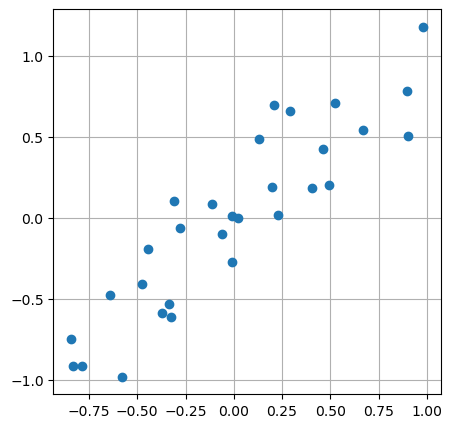

In [91]:
data=load_sample_data_pca()

n_samples,n_dim=data.shape

print('We have ',n_samples, 'samples of dimension ', n_dim)

plt.figure(figsize=((5,5)))
plt.grid()
plt.plot(data[:,0],data[:,1],'o')
plt.show()

The data set is almost one dimensional. PCA will confirm this result.

As with most of sklearn functionalities, we need first to create a PCA object. We will use the object methods to perform PCA.

In [96]:
pca=PCA(n_components=2) 

A call to the pca.fit method computes the principal components

In [98]:
pca.fit(data)

PCA(n_components=2)

In [106]:
type(data)
print(data)

[[ 0.21057607  0.69621761]
 [ 0.52527591  0.7073057 ]
 [-0.30921026  0.10326996]
 [ 0.13063548  0.48603246]
 [ 0.89487417  0.78251433]
 [ 0.90156644  0.50342956]
 [-0.63984911 -0.4767921 ]
 [-0.47653398 -0.4090471 ]
 [-0.78808533 -0.91687445]
 [-0.00940005 -0.27469943]
 [-0.83126731 -0.91510128]
 [ 0.02264671  0.00123308]
 [ 0.40726836  0.18615005]
 [-0.33404517 -0.53260628]
 [ 0.46149007  0.42882258]
 [ 0.2907059   0.66088593]
 [-0.84305597 -0.74715695]
 [ 0.22668844  0.01982242]
 [-0.37251484 -0.58489122]
 [-0.06081734 -0.09654915]
 [-0.32396957 -0.60891311]
 [ 0.4952561   0.20628093]
 [-0.0101123   0.01356887]
 [-0.57728426 -0.98040878]
 [ 0.1982783   0.19150995]
 [ 0.6696098   0.54143212]
 [-0.27829267 -0.06095994]
 [-0.44710397 -0.19071163]
 [-0.11507722  0.08566181]
 [ 0.98174757  1.18057409]]


Now the pca.components_ attribute contains the principal components. We can print them alongside with the data and check that they constitute an orthonormal basis.

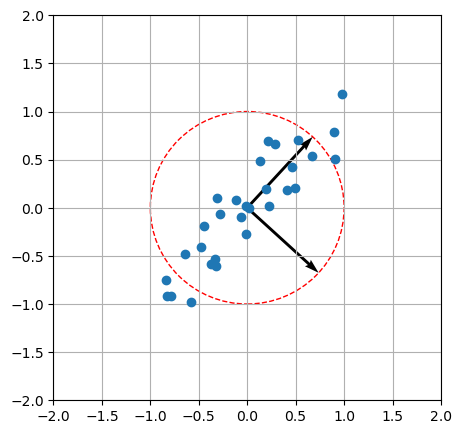

In [100]:
plt.figure(figsize=((5,5)))
plt.grid()
plt.plot(data[:,0],data[:,1],'o')

circle=plt.Circle((0, 0), 1.0, linestyle='--', color='red',fill=False)
ax=plt.gca()
ax.add_artist(circle)

for vec in pca.components_:
    plt.quiver([0], [0], [vec[0]], [vec[1]], angles='xy', scale_units='xy', scale=1)

plt.xlim(-2,2)
plt.ylim(-2,2)
plt.show()

The pca.explained_variance_ratio_ attribute contains the explained variance. In this case we see that already the first reconstructed vector explains 95% of the variance.

In [102]:
print(pca.explained_variance_ratio_)

[0.95140729 0.04859271]


To compute the reconstructed vectors for k=1 we first need to compute the scores and then multiply by the basis vectors:

$$\mathbf x_{rec}=\sum_{i<M} (\mathbf x \cdot \mathbf k_i) \mathbf k_i$$

In [108]:
k=1
scores=pca.transform(data)
res=np.dot(scores[:,:k], pca.components_[:k,:] )

C:\Users\vuill\AppData\Local\Temp\ipykernel_20208\1393811091.py:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([a,c],[b,d],'-', linestyle = '--', color='red')


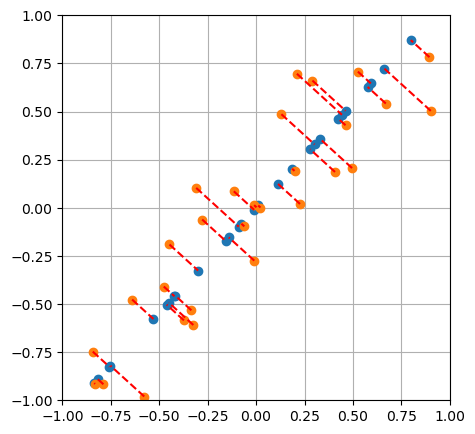

In [110]:
plt.figure(figsize=((5,5)))
plt.plot(res[:,0],res[:,1],'o')
plt.plot(data[:,0],data[:,1],'o')

for a,b,c,d in zip(data[:,0],data[:,1],res[:,0],res[:,1]) :
    plt.plot([a,c],[b,d],'-', linestyle = '--', color='red')

plt.grid()

plt.xlim(-1.0,1.0)
plt.ylim(-1.0,1.0)
plt.show()

The same procedure is followed for high dimensional datasets. Here we generate random data which lies almost on a 6-dimensional subspace. The resulting scree plot can be used to find this result in a semi-automatic fashion.

Let's redo the same now with our survey dataset, to review the concepts again and think "high"-dimensionally.

In [13]:
pca=PCA()
pca.fit(music_data)

PCA()

In [22]:
music_data

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,Punk,"Hiphop, Rap","Reggae, Ska","Swing, Jazz",Rock n roll,Alternative,Latino,"Techno, Trance",Opera
0,5.0,3.0,2.0,1.0,2.0,2.0,1.0,5.0,5.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0
1,4.0,4.0,2.0,1.0,1.0,1.0,2.0,3.0,5.0,4.0,4.0,1.0,3.0,1.0,4.0,4.0,2.0,1.0,1.0
2,5.0,5.0,2.0,2.0,3.0,4.0,5.0,3.0,5.0,3.0,4.0,1.0,4.0,3.0,5.0,5.0,5.0,1.0,3.0
3,5.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,4.0,2.0,2.0,1.0,2.0,5.0,1.0,2.0,1.0
4,5.0,3.0,4.0,3.0,2.0,4.0,3.0,5.0,3.0,1.0,2.0,5.0,3.0,2.0,1.0,2.0,4.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,5.0,2.0,5.0,2.0,2.0,5.0,4.0,4.0,4.0,3.0,2.0,4.0,1.0,5.0,4.0,4.0,3.0,3.0,2.0
1006,4.0,4.0,5.0,1.0,3.0,4.0,1.0,4.0,1.0,1.0,4.0,1.0,1.0,2.0,3.0,1.0,3.0,4.0,1.0
1007,4.0,3.0,1.0,1.0,2.0,2.0,2.0,3.0,4.0,1.0,2.0,3.0,3.0,2.0,2.0,5.0,1.0,1.0,1.0
1008,5.0,3.0,3.0,3.0,1.0,3.0,1.0,3.0,4.0,1.0,1.0,2.0,2.0,3.0,2.0,5.0,2.0,2.0,1.0


In [21]:
music_data.shape

(931, 19)

In [20]:
music_columns.shape

(19,)

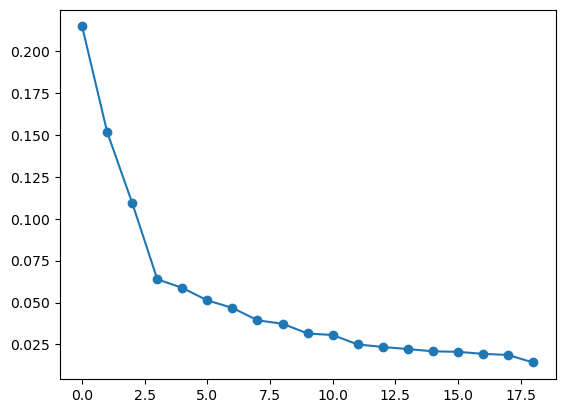

In [14]:
plt.plot(pca.explained_variance_ratio_,'-o')

In [15]:
df = pd.DataFrame(pca.components_.transpose(),
                  columns = [f'V_{i+1}' for i in range(len(music_columns))],
                  index=music_columns)
df

,V_1,V_2,V_3,V_4,V_5,V_6,V_7,V_8,V_9,V_10,V_11,V_12,V_13,V_14,V_15,V_16,V_17,V_18,V_19
Music,0.034327,-0.030242,-0.058575,0.003401,-0.005648,0.070442,-0.072589,0.046377,-0.002965,-0.044203,0.005060,-0.112661,0.011120,0.114572,0.140985,-0.138319,-0.223307,0.223824,-0.902855
Slow songs or fast songs,-0.038844,0.001008,-0.150553,0.058194,-0.098439,0.037892,0.008159,-0.023107,-0.106553,0.048223,0.046499,-0.469155,-0.196216,0.302002,0.408006,-0.491768,0.244483,0.258269,0.245515
Dance,-0.108185,-0.351080,-0.242687,0.144840,-0.215340,0.140691,0.072253,0.150583,-0.106101,-0.007872,-0.225787,-0.284248,-0.454947,-0.441326,0.126784,0.223653,-0.171112,-0.224983,-0.016402
Folk,0.198776,-0.190829,0.165786,0.110605,-0.005172,-0.214301,0.350442,0.290317,-0.367466,-0.340010,-0.047813,-0.350712,0.189948,0.291911,-0.329439,0.068718,-0.136498,-0.024515,0.040103
Country,0.170824,-0.140712,0.074469,0.013157,-0.127616,-0.205966,0.493252,0.371091,0.024814,0.188480,0.321041,0.317403,0.049683,-0.341773,0.253690,-0.175941,0.060453,0.217247,-0.013842
Classical music,0.321165,-0.154089,0.246121,0.335864,0.050521,-0.112244,-0.242079,0.058894,0.227351,-0.237305,-0.084052,0.144460,-0.040855,0.015306,0.203028,-0.416664,-0.063652,-0.515503,-0.006618
Musical,0.195235,-0.315976,0.227786,-0.189421,-0.212367,-0.041638,-0.419096,-0.113744,-0.242206,0.473885,0.297234,-0.237463,0.195298,-0.144131,-0.132668,-0.080119,-0.153356,-0.055279,0.037238
Pop,-0.102153,-0.323553,-0.093759,-0.191536,-0.354285,0.196396,-0.257379,0.313967,0.084972,-0.267280,-0.222586,0.120422,0.331245,-0.039526,-0.088276,-0.056829,0.484205,0.097763,-0.038331
Rock,0.307950,0.116657,-0.196066,-0.138037,-0.298001,0.155711,-0.095854,0.090328,0.178293,-0.158085,-0.070379,0.057146,0.217821,0.127137,0.302390,0.159884,-0.586401,0.189754,0.279609
Metal or Hardrock,0.337369,0.277790,-0.224637,0.107211,-0.356716,-0.218770,0.118212,-0.386633,0.140126,-0.183835,0.168455,-0.283392,0.181362,-0.251764,-0.013434,0.139735,0.303840,-0.133485,-0.142317


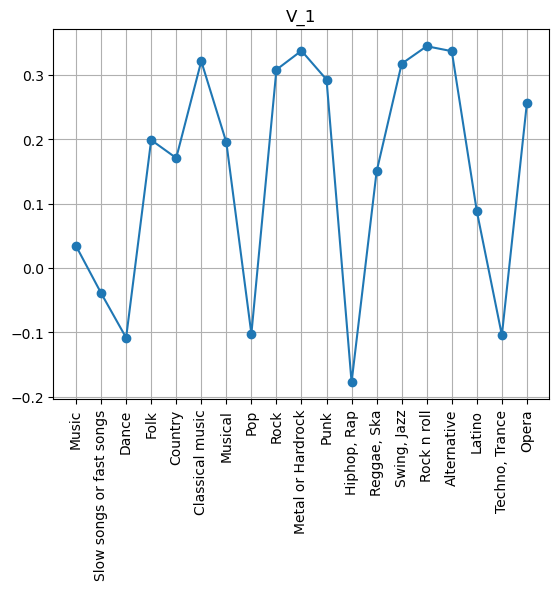

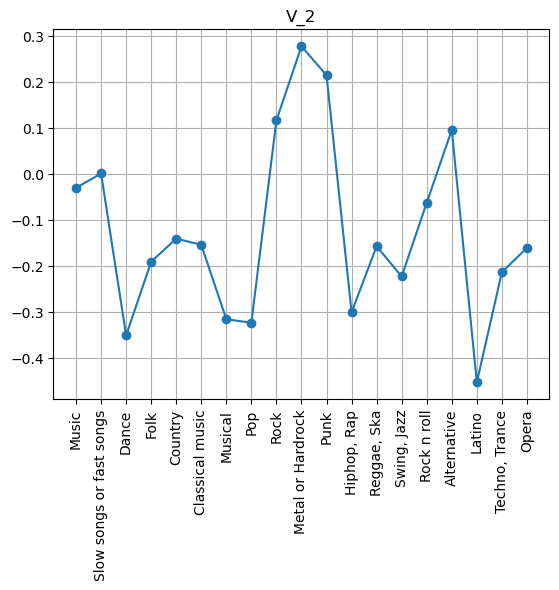

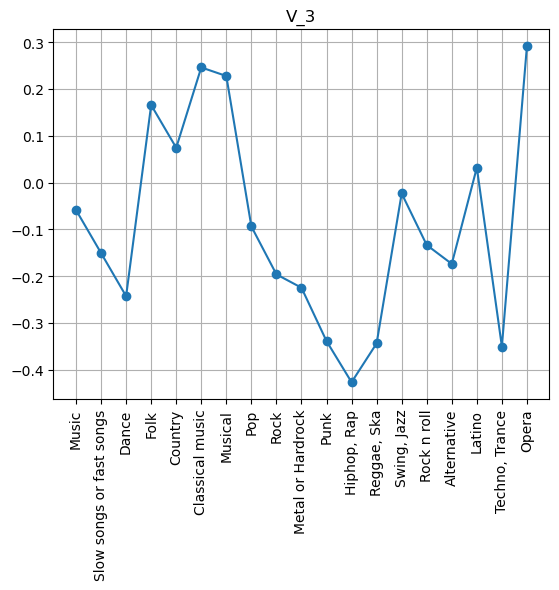

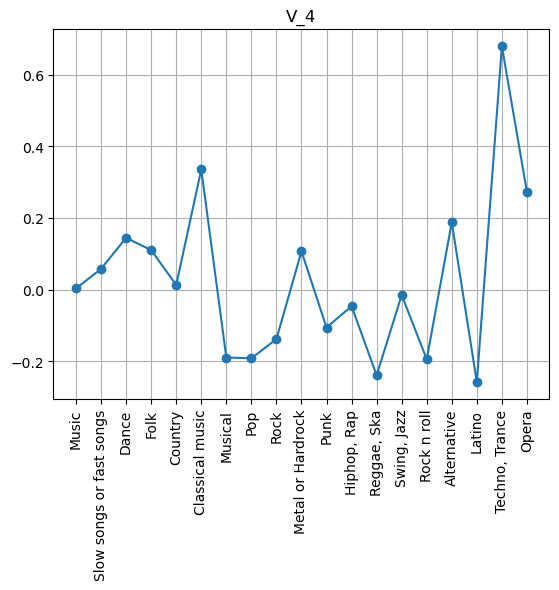

In [126]:
for vector in ['V_1','V_2','V_3','V_4']:
    plt.figure()
    plt.title(vector)
    plt.plot(np.arange(len(music_columns)),list(df[vector]),'-o')
    _=plt.xticks(np.arange(len(music_columns)),music_columns, rotation=90)
    plt.grid()

In [129]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from skimage.util import random_noise

# Example adapted from https://scikit-learn.org/stable/auto_examples/applications/plot_digits_denoising.html: 

import matplotlib.pyplot as plt
def plot_digits(X, title):
    """Small helper function to plot 100 digits."""
    fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(8, 8))
    for img, ax in zip(X, axs.ravel()):
        ax.imshow(img.reshape((16, 16)), cmap="Greys")
        ax.axis("off")
    fig.suptitle(title, fontsize=24)
X, y = fetch_openml(data_id=41082, as_frame=False, return_X_y=True)
X_noise = random_noise(X, mode='gaussian', var=0.1)

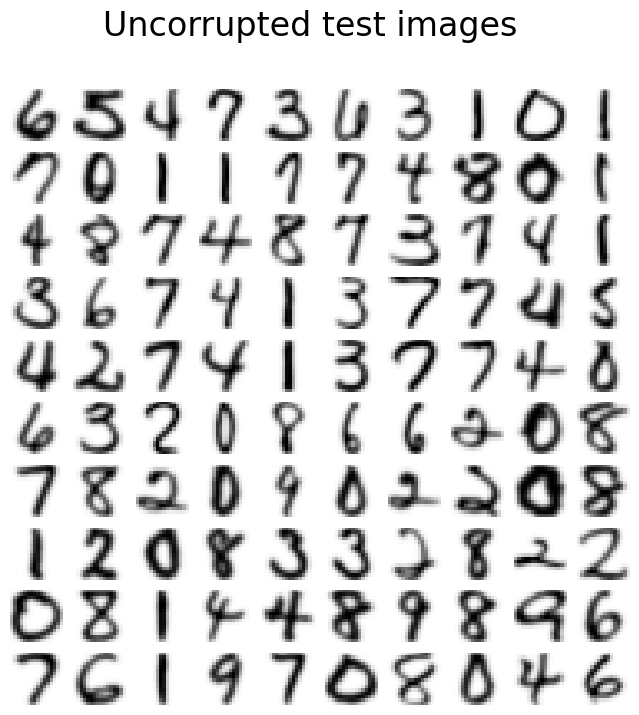

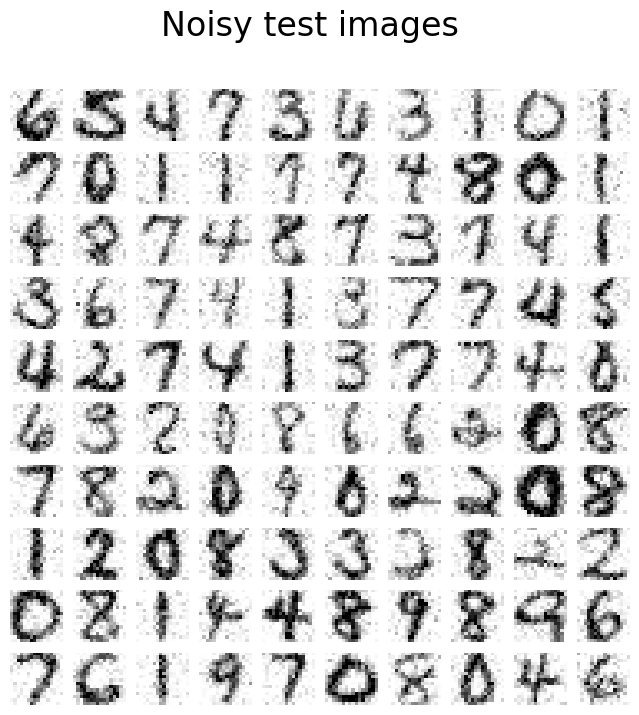

In [131]:
plot_digits(X, "Uncorrupted test images")
plot_digits(X_noise, f"Noisy test images")

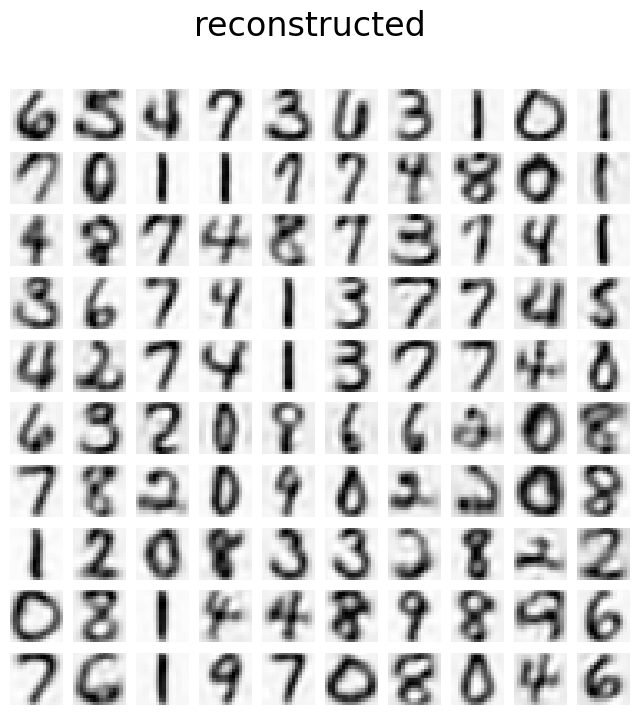

In [133]:
pca = PCA(n_components=32)
pca.fit(X)
X_reconstructed = pca.inverse_transform(pca.transform(X))
plot_digits(X_reconstructed,'reconstructed')

## EXERCISE 2 : pressure response to body movements

In [ ]:
# Suppose you have 20 sensors measuring blood pressure in different parts of the bad during the day,
# reporting measurments every second.
#
# MODELLING: We assume that some particular movements of the body will produce a correlated response in blood pressure.
# Furthermore, these body movements do not happen independently but are superposing each other,
# so that the final pressure measured is a sum of all of them.
#
# You are given a dataset of recording. Your task is to use PCA to discover, under these assumptions,
# how many are the body movements producing these resposes, and to characterize the blood pressure response along these 20 sensors.

# To do that:

# 1. Load the data using the function data=load_multidimensional_data_pca() , check the dimensionality of the data and plot them.
data=...
n_samples,n_dim=...
print('We have ',n_samples, 'samples of dimension ', n_dim)

# 2. Define a PCA object and perform the PCA fitting.
pca=PCA()
pca....

# 3. Check the explained variance ratio and select best number of components. How many are the typical body movements?
print(pca...)
plt.plot(...)

# 3. Plot the pattern response associated to the typical body movements by exploring the principal vectors.
for vec in pca.components_[:...]:
    ...

## Final Notes:

### Note 1: Uncorrelation of PCA scores:


PCA is able therefore to make this mapping:

$(x_1,...,x_D) \rightarrow (y_1,..,y_M)$

Here we focused on data compression, but it is also very important that $y_1,...,y_M$ are uncorrolated for interpratibility purposes. Being uncorrelated means (roughly) that in our dataset we can change one variable without affecting the others. The dimensions 1,...,M are often therefore more interpretable and providing more information.

### Note 2: Intepretation of PCA plot when M=2

When $M=2$ the scatterplot of $s_1$ vs. $s_2$ is an effective 2 dimensional visualization of the dataset. If such a scatterplot shows actual patterns in the data depends on the dataset. 

The original features can be represented as arrows in the 2_D scatterplot, and the projection of the points onto the respective arrow is proportional to the value of the feature. This is called a biplot. See https://www.fbbva.es/wp-content/uploads/2017/05/dat/DE_2010_biplots_in_practice.pdf for a nice introduction. But one must be careful that a biplot makes sense only if the main features of the dataset can be represented linearly in two dimensions.


<img src="https://github.com/neworldemancer/DSF5/raw/master/figures/pca-ames.png" width="60%"/>

<img src="https://github.com/neworldemancer/DSF5/raw/master/figures/pca-wine.png" width="60%"/>

<img src="https://github.com/neworldemancer/DSF5/raw/master/figures/pca-breast-cancer.png" width="60%"/>